In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cuda')

# Load and preprocess data
df = pd.read_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')  
# df = df.loc[(df['material'] != 'GaAs') & (df['material'] != 'CaF2')].reset_index(drop=True)
df = df.loc[(df['material'] != 'LSAT')].reset_index(drop=True)

epsilon = df['eps1'].values + 1j * df['eps2'].values
beta = (epsilon - 1) / (epsilon + 1)
df['beta1'] = beta.real
df['beta2'] = beta.imag
materials = df['material'].values

NUMBER_OF_EPOCHS = 2000
BATCH_SIZE = 32

In [2]:

# Prepare features and targets
X = df[['beta1', 'beta2']]
y = df[['Sn_exp_real', 'Sn_exp_imag']]

# Convert to numpy arrays
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, materials_train, materials_test = train_test_split(
     X, y, materials, test_size=0.2, random_state=42)

# Scale numerical features
nn_scaler = StandardScaler()
X_train = nn_scaler.fit_transform(X_train)
X_test = nn_scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Create Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

batch_size = BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        return self.output(out)

# Initialize model
input_size = X_train.shape[1]
nn_model = NeuralNet(input_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)
 
# Training loop
num_epochs = NUMBER_OF_EPOCHS
epochs_dict = {}
for epoch in range(num_epochs):
    nn_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    nn_model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = nn_model(inputs)
            test_loss += criterion(outputs, labels).item()
            
    epochs_dict[f'{epoch+1}'] = {'loss': loss.item(), 'test_loss': test_loss/len(test_loader)}
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

# Final evaluation
nn_model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = nn_model(inputs)
        total_loss += criterion(outputs, labels).item()
        
print(f'Final Test Loss: {total_loss/len(test_loader):.4f}')

# Final evaluation: run predictions on the test set
nn_model.eval()
with torch.no_grad():
    # Ensure X_test is on the proper device
    y_pred_tensor = nn_model(X_test.to(device))
    # Bring predictions back to CPU and convert to numpy
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test.cpu().numpy()

AssertionError: Torch not compiled with CUDA enabled

In [ ]:

# Prepare features and targets
X = df[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag']]
y = df[['Sn_exp_real', 'Sn_exp_imag']]

# Convert to numpy arrays
X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

# Split data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, materials_train, materials_test = train_test_split(
     X, y, materials, test_size=0.2, random_state=42)

# Scale numerical features
hnn_scaler = StandardScaler()
X_train = hnn_scaler.fit_transform(X_train)
X_test = hnn_scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Create Dataset and DataLoader
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 512#BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define neural network architecture
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, 8)
        self.layer2 = nn.Linear(8, 8)
        self.layer3 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.relu(self.layer1(x))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        return self.output(out)

# Initialize model
input_size = X_train.shape[1]
hnn_model = NeuralNet(input_size).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(hnn_model.parameters(), lr=1e-3)
 
# Training loop
num_epochs = NUMBER_OF_EPOCHS
epochs_dict = {}
for epoch in range(num_epochs):
    hnn_model.train()
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = hnn_model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Validation
    hnn_model.eval()
    with torch.no_grad():
        test_loss = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = hnn_model(inputs)
            test_loss += criterion(outputs, labels).item()
            
    epochs_dict[f'{epoch+1}'] = {'loss': loss.item(), 'test_loss': test_loss/len(test_loader)}
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Loss: {test_loss/len(test_loader):.4f}')

# Final evaluation
hnn_model.eval()
with torch.no_grad():
    total_loss = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = hnn_model(inputs)
        total_loss += criterion(outputs, labels).item()
        
print(f'Final Test Loss: {total_loss/len(test_loader):.4f}')

# Final evaluation: run predictions on the test set
hnn_model.eval()
with torch.no_grad():
    # Ensure X_test is on the proper device
    y_pred_tensor = hnn_model(X_test.to(device))
    # Bring predictions back to CPU and convert to numpy
    y_pred = y_pred_tensor.cpu().numpy()
    y_true = y_test.cpu().numpy()

Epoch [100/2000], Loss: 0.0184, Test Loss: 0.0227
Epoch [200/2000], Loss: 0.0219, Test Loss: 0.0189
Epoch [300/2000], Loss: 0.0140, Test Loss: 0.0158
Epoch [400/2000], Loss: 0.0160, Test Loss: 0.0151
Epoch [500/2000], Loss: 0.0105, Test Loss: 0.0147
Epoch [600/2000], Loss: 0.0131, Test Loss: 0.0146
Epoch [700/2000], Loss: 0.0105, Test Loss: 0.0142
Epoch [800/2000], Loss: 0.0081, Test Loss: 0.0135
Epoch [900/2000], Loss: 0.0088, Test Loss: 0.0133
Epoch [1000/2000], Loss: 0.0104, Test Loss: 0.0132
Epoch [1100/2000], Loss: 0.0176, Test Loss: 0.0130
Epoch [1200/2000], Loss: 0.0110, Test Loss: 0.0130
Epoch [1300/2000], Loss: 0.0080, Test Loss: 0.0127
Epoch [1400/2000], Loss: 0.0087, Test Loss: 0.0125
Epoch [1500/2000], Loss: 0.0055, Test Loss: 0.0124
Epoch [1600/2000], Loss: 0.0109, Test Loss: 0.0127
Epoch [1700/2000], Loss: 0.0127, Test Loss: 0.0127
Epoch [1800/2000], Loss: 0.0123, Test Loss: 0.0130
Epoch [1900/2000], Loss: 0.0063, Test Loss: 0.0128
Epoch [2000/2000], Loss: 0.0063, Test Lo

In [ ]:
df = pd.read_csv(r'C:\nano_optics_ml_data\processed\article_main_data.csv')  # Replace with your file path

epsilon = df['eps1'].values + 1j * df['eps2'].values
beta = (epsilon - 1) / (epsilon + 1)
df['beta1'] = beta.real
df['beta2'] = beta.imag
materials = df['material'].values

test_df = df.query("""material == 'LSAT'""")[['beta1', 'beta2', 'Sn_fdm_real', 'Sn_fdm_imag', 'f', 'Sn_exp_real','Sn_exp_imag']].copy()

x_values = (nn_scaler.transform(test_df.drop(columns=['f', 'Sn_exp_real','Sn_exp_imag', 'Sn_fdm_real', 'Sn_fdm_imag']).values))

x_torch = torch.from_numpy(x_values).float()

output = nn_model(x_torch.to(device))
nn_output_df = pd.DataFrame(output.to('cpu').detach().numpy(), columns=['S2_pred_nn_real', 'S2_pred_nn_imag'])

output_df = pd.concat([test_df.reset_index(), nn_output_df], axis=1)

In [ ]:
x_values = (hnn_scaler.transform(test_df.drop(columns=['f', 'Sn_exp_real','Sn_exp_imag']).values))

x_torch = torch.from_numpy(x_values).float()

output = hnn_model(x_torch.to(device))
hnn_output_df = pd.DataFrame(output.to('cpu').detach().numpy(), columns=['S2_pred_hnn_real', 'S2_pred_hnn_imag'])

output_df = pd.concat([output_df, hnn_output_df], axis=1)

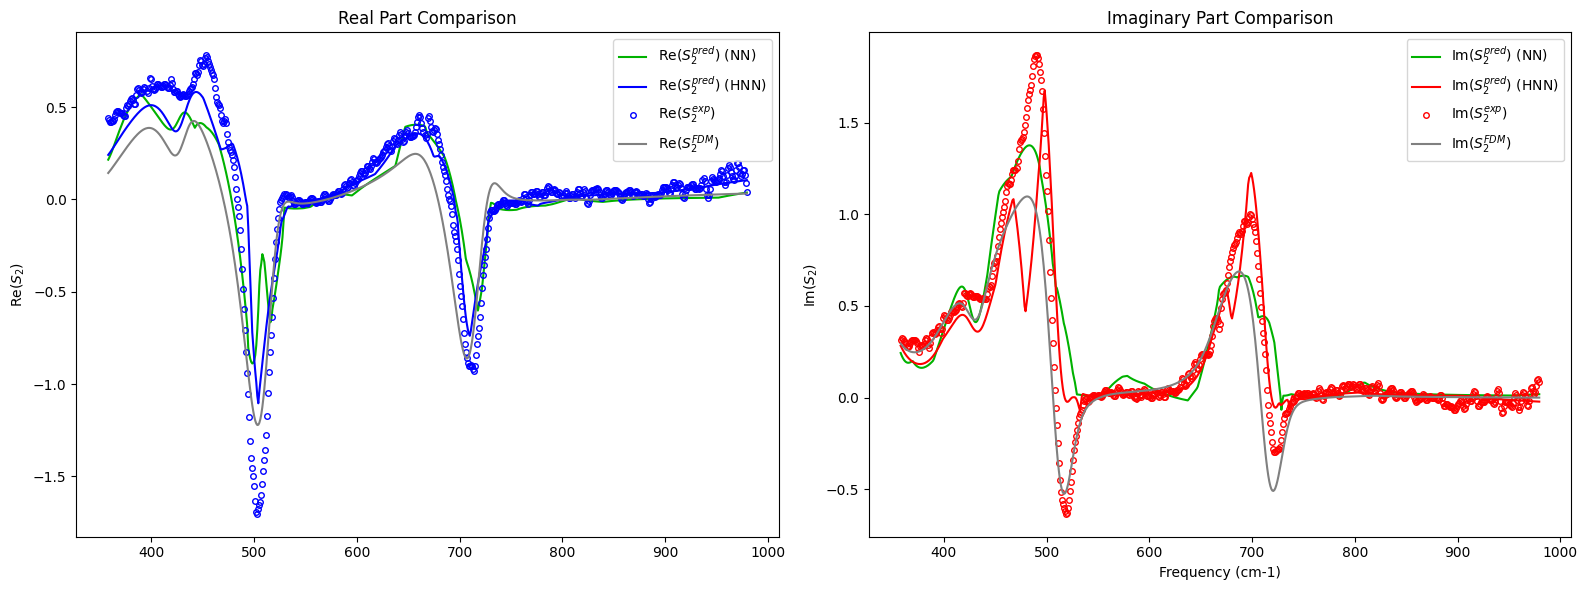

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axes[0].plot(output_df['f'], output_df['S2_pred_nn_real'], 
             label=r'Re($S^{pred}_2$) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[0].plot(output_df['f'], output_df['S2_pred_hnn_real'], 
             label=r'Re($S^{pred}_2$) (HNN)', linestyle='-', markersize=4, color='blue')
axes[0].plot(output_df['f'], output_df['Sn_exp_real'], 
             label=r'Re($S^{exp}_2$)', marker='o', linestyle='', markersize=4,markerfacecolor='none', markeredgecolor='blue',)
axes[0].plot(output_df['f'], output_df['Sn_fdm_real'], 
             label=r'Re($S^{FDM}_2$)', linestyle='-', markersize=4, color='gray')
axes[0].set_ylabel('Re($S_2$)')
axes[0].set_title('Real Part Comparison')
axes[0].legend()

axes[1].plot(output_df['f'], output_df['S2_pred_nn_imag'], 
             label=r'Im($S^{pred}_2$) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[1].plot(output_df['f'], output_df['S2_pred_hnn_imag'], 
             label=r'Im($S^{pred}_2$) (HNN)', linestyle='-', markersize=4, color='red')
axes[1].plot(output_df['f'], output_df['Sn_exp_imag'], 
             label=r'Im($S^{exp}_2$)', marker='o', linestyle='', markersize=4, markerfacecolor='none', markeredgecolor='red',)
axes[1].plot(output_df['f'], output_df['Sn_fdm_imag'], 
             label=r'Im($S^{FDM}_2$)', linestyle='-', color='gray')
axes[1].set_ylabel('Im($S_2$)')
axes[1].set_title('Imaginary Part Comparison')
axes[1].legend()
# axes[1].grid(True)
axes[1].set_xlabel('Frequency (cm-1)')

plt.tight_layout()
plt.show()
